In [1]:
import sys
sys.path.append("..")
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.io
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D  
import rbf_gauss
from scipy.io import savemat

In [2]:
# Load multisine data from matlab
mat = scipy.io.loadmat("u_data_CL240000.mat")
u_data = mat["u_data"]

mat = scipy.io.loadmat("y_dataCL240000.mat")
y_data = mat["y_data"]

# convert data to tensors
u_data = np.array(u_data)
y_data = np.array(y_data)

u_data = torch.FloatTensor(u_data).transpose(0,1)
#u_data = u_data[0,:1000].unsqueeze(0).transpose(0,1)
y_data = torch.FloatTensor(y_data).transpose(0,1)
#y_data = y_data[0,:1000].unsqueeze(0).transpose(0,1)
#y_data = y_data[0,:].unsqueeze(1)
#torch.reshape(y_data,(1000, 1))
input_dim = list(u_data.shape)[1]
output_dim = list(y_data.shape)[1]
print(f"input_dim = {input_dim}")
print(f"output_dim = {output_dim}")

FileNotFoundError: [Errno 2] No such file or directory: 'y_dataCL240000.mat'

In [18]:
y_data.shape[0]

10000

In [19]:
# Hyper parameters
T_ini = 3
n_basis = 40
T = y_data.shape[0]
in_features = T_ini * 2
out_features = n_basis
N = 4

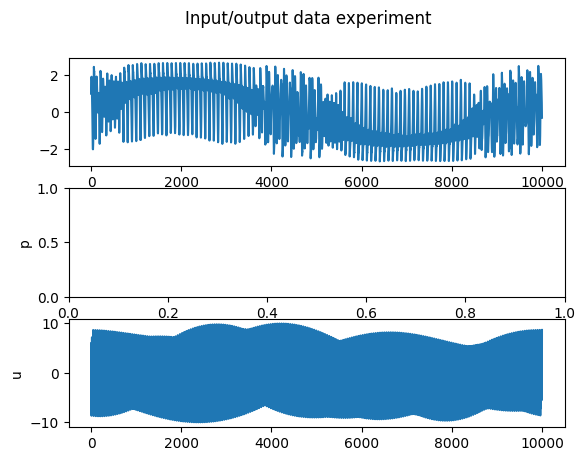

<Figure size 640x480 with 0 Axes>

In [20]:
# Plot the pendulum trajectory together with the input
fig, axs = plt.subplots(3)
fig.suptitle("Input/output data experiment")
axs[0].plot(y_data[:,])
#axs[1].plot(y_data[:,1])
axs[2].plot(u_data)
axs[1].set(ylabel="p")
#axs[1].set(ylabel="theta")
axs[2].set(ylabel="u")
plt.show()

plt.savefig('destination_path.eps', format='eps')

In [21]:
U_ini = torch.transpose(u_data[0 : T_ini - 1,0].unsqueeze(1), 0, 1)
U_0_Nm1 = torch.transpose(u_data[T_ini - 1 : T_ini + N - 1,0].unsqueeze(1), 0, 1)
if input_dim > 1:
    for j in range(input_dim-1):
        U_ini = torch.cat((U_ini, torch.transpose(u_data[0 : T_ini - 1,j].unsqueeze(1), 0, 1)),1)
        U_0_Nm1 = torch.cat((U_0_Nm1, torch.transpose(u_data[T_ini - 1 : T_ini + N - 1,1].unsqueeze(1), 0, 1)),1)
# print(f"U_ini = {(U_ini).shape}")           
# print(f"U_0_Nm1 = {(U_0_Nm1).shape}")        

Y_ini = torch.transpose(y_data[1 : T_ini + 1,0].unsqueeze(1), 0, 1)
Y_1_N = torch.transpose(y_data[T_ini + 1 : T_ini + 1 + N,0].unsqueeze(1), 0, 1)
if output_dim > 1:
    for p in range(output_dim-1):
        Y_ini = torch.cat((Y_ini, torch.transpose(y_data[1 : T_ini + 1,p].unsqueeze(1), 0, 1)),1)
        Y_1_N = torch.cat((Y_1_N, torch.transpose(y_data[T_ini + 1 : T_ini + 1 + N,p].unsqueeze(1), 0, 1)),1)

# print(f"Y_ini = {(Y_ini).shape}")           
# print(f"Y_1_N = {(Y_1_N).shape}")       

for i in range(T - T_ini - 1 - N):
    if i < 100:
        print(i)
    U_ini_part =  torch.transpose(u_data[i + 1 : T_ini + i,0].unsqueeze(1), 0, 1)
    U_0_Nm1_part = torch.transpose(u_data[T_ini + i : T_ini + i + N,0].unsqueeze(1), 0, 1)
    if input_dim > 1:
        for j in range(input_dim-1):
            U_ini_part =  torch.cat((U_ini_part, torch.transpose(u_data[i + 1 : T_ini + i,j].unsqueeze(1), 0, 1)), 1)
            U_0_Nm1_part = torch.cat((U_0_Nm1_part ,torch.transpose(u_data[T_ini + i : T_ini + i + N,j].unsqueeze(1), 0, 1)),1)
    
    Y_ini_part =  torch.transpose(y_data[i + 2 : T_ini + 2 + i,0].unsqueeze(1), 0, 1)
    Y_1_N_part = torch.transpose(y_data[T_ini + 2 + i : T_ini + 2 + i + N,0].unsqueeze(1), 0, 1)
    if output_dim > 1:
        for p in range(output_dim-1):
            Y_ini_part =  torch.cat((Y_ini_part, torch.transpose(y_data[i + 2 : T_ini + 2 + i,p].unsqueeze(1), 0, 1)), 1)
            Y_1_N_part = torch.cat((Y_1_N_part ,torch.transpose(y_data[T_ini + 2 + i : T_ini + 2 + i + N,p].unsqueeze(1), 0, 1)),1)
#             print(f"Y_ini_part = {(Y_ini_part).shape}")
#             print(f"Y_1_N_part = {(Y_1_N_part).shape}")
                                   
    U_ini =  torch.cat((U_ini, U_ini_part), 0)        
    U_0_Nm1 = torch.cat((U_0_Nm1,U_0_Nm1_part ))
#     print(f"U_ini = {(U_ini).shape}")
#     print(f"U_0_Nm1 = {(U_0_Nm1).shape}")
    Y_ini = torch.cat((Y_ini, Y_ini_part), 0)
    Y_1_N = torch.cat((Y_1_N, Y_1_N_part), 0)    
#     print(f"Y_ini = {(Y_ini).shape}")
#     print(f"Y_1_N = {(Y_1_N).shape}") 
        
X = torch.cat((U_ini, Y_ini, U_0_Nm1), 1)
y = Y_1_N

print(f"X = {(X).shape}")
print(f"y = {(y).shape}")
    
#X_train, X_test, y_train, y_test = train_test_split(
   # X, y, test_size=0.2, random_state=41
#)    
X_train, X_test = X[0:8000,:], X[8000:]

y_train, y_test = y[0:8000,:], y[8000:]


print(f"X_train = {(X_train).shape}")
print(f"y = {(y).shape}")
print(f"y_train = {(y_train).shape}")

X_train_1 = X_train[:, 0 : (2 * T_ini - 1)*input_dim]
X_train_2 = X_train[:, (2 * T_ini - 1)*input_dim :]

X_test_1 = X_test[:, 0 : (2 * T_ini - 1)*input_dim]
X_test_2 = X_test[:, (2 * T_ini - 1)*input_dim :] 

    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
X = torch.Size([9993, 9])
y = torch.Size([9993, 4])
X_train = torch.Size([8000, 9])
y = torch.Size([9993, 4])
y_train = torch.Size([8000, 4])


In [22]:
print(f"X_train = {(X_train).shape}")
print(f"X_test = {(X_test).shape}")
print(f"X_train_1 = {(X_train_1).shape}")
print(f"X_train_2 = {(X_train_2).shape}")
print(f"y_train = {(y_train).shape}")
print(f"y_test = {(y_test).shape}")


X_train = torch.Size([8000, 9])
X_test = torch.Size([1993, 9])
X_train_1 = torch.Size([8000, 5])
X_train_2 = torch.Size([8000, 4])
y_train = torch.Size([8000, 4])
y_test = torch.Size([1993, 4])


In [23]:
# Create the neural network
class Model(nn.Module):
    def __init__(self, in_1_features, out_1_features, in_2_features, out_2_features):
        super().__init__()
        basis_func = rbf_gauss.RBF_gaussian.gaussian
        self.l_1 = rbf_gauss.RBF_gaussian(in_1_features, out_1_features,basis_func)
        self.l_2 = nn.Linear(in_2_features, out_2_features, bias=False)

    def forward(self, x1, x2):
        x1 = self.l_1(x1)
        x = torch.cat((x1, x2), 1)
        x = self.l_2(x)
        return x


Epoch: 0 and the loss: 2.557634115219116
Epoch: 10 and the loss: 2.469244956970215
Epoch: 20 and the loss: 2.3929240703582764
Epoch: 30 and the loss: 2.3282034397125244
Epoch: 40 and the loss: 2.273912191390991
Epoch: 50 and the loss: 2.2285168170928955
Epoch: 60 and the loss: 2.1906309127807617
Epoch: 70 and the loss: 2.1590476036071777
Epoch: 80 and the loss: 2.1326816082000732
Epoch: 90 and the loss: 2.110578775405884
Epoch: 100 and the loss: 2.091919422149658
Epoch: 110 and the loss: 2.075995683670044
Epoch: 120 and the loss: 2.062190055847168
Epoch: 130 and the loss: 2.0499629974365234
Epoch: 140 and the loss: 2.03884220123291
Epoch: 150 and the loss: 2.0284173488616943
Epoch: 160 and the loss: 2.0183303356170654
Epoch: 170 and the loss: 2.0082714557647705
Epoch: 180 and the loss: 1.9979699850082397
Epoch: 190 and the loss: 1.9871928691864014
Epoch: 200 and the loss: 1.9757379293441772
Epoch: 210 and the loss: 1.9634324312210083
Epoch: 220 and the loss: 1.9501298666000366
Epoch: 2

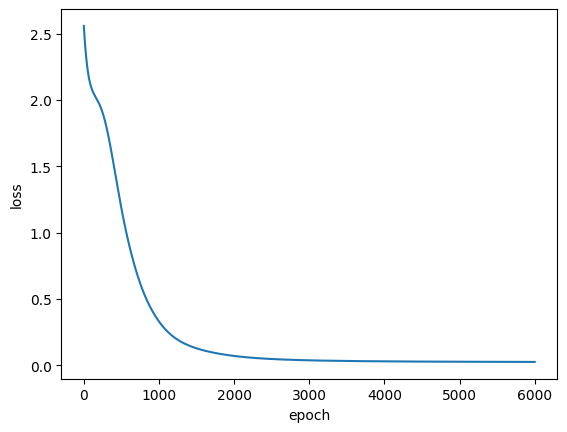

In [24]:
# create a manual seed for randomization
torch.manual_seed(41)
# Create an instance of our model
model = Model((2 * T_ini - 1)*input_dim, (n_basis), (n_basis + N*output_dim), (N)*output_dim)
# Set the criterion for our model to measure the error
criterion = nn.MSELoss()
# Choose Adam optimizer, lr = Learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-5)

# Train our model!
# Epochs? (one run thru all the training data in our network)
epochs = 6000
losses = []

for i in range(epochs):
    # Go forward and get a prediction
    y_pred = model.forward(X_train_1, X_train_2)  # get results
    #print(f"y_pred = {(y_pred).shape}")
    # Measure the loss/error,
    loss = criterion(y_pred, y_train)

    # keep track of our losses
    losses.append(loss.detach().numpy())

    # print every 10 epoch
    if i % 10 == 0:
        print(f"Epoch: {i} and the loss: {loss}")

    # Do some back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


# create a plot
plt.plot(range(epochs), losses)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()


In [25]:
with torch.no_grad():
    y_eval = model.forward(X_test_1, X_test_2)
type(y_test)

torch.Tensor

In [26]:
# evaluate the model on the test data set
with torch.no_grad():  # turn off backpropagation
    y_eval = model.forward(X_test_1, X_test_2)  # are features from our test set
    loss = criterion(y_eval, y_test)  # Find the loss or error

# print the predicted output and the test data
print(f"y_eval = {y_eval}")
print(f"y_test = {y_test}")
print(f"y_eval-y_test = {y_eval-y_test}")


print("test 1")

# Convert the model parameters to numpy arrays
centers = model.l_1.centers.detach().numpy()
log_sigmas = model.l_1.log_sigmas.detach().numpy()
weight = model.l_2.weight.detach().numpy()

print("test 2")
# save the parameters for use in matlab
# convert parameters to arrays so they can be saved as .mat files
centers = {"centers": centers}
log_sigmas = {"log_sigmas": log_sigmas}
weight = {"weight": weight}
X_test = {"X_test": X_test}
y_test = {"y_test": y_test}

print("test 3")

# save as .mat file

savemat(
    "centers.mat",
    centers,
)
savemat(
    "log_sigmas.mat",
    log_sigmas,
)
# savemat(r"weight.mat", weight)


print(f"u_data = {u_data}")
print(f"u_data.shape = {u_data.shape}")

y_eval = tensor([[1.3710, 1.5725, 1.7251, 1.8463],
        [1.5631, 1.6988, 1.7459, 1.7541],
        [1.6813, 1.7200, 1.7235, 1.7041],
        ...,
        [0.7110, 0.4976, 0.3165, 0.1368],
        [0.5225, 0.3919, 0.2633, 0.1445],
        [0.3449, 0.2137, 0.1215, 0.0491]])
y_test = tensor([[ 1.3448,  1.5267,  1.6418,  1.6651],
        [ 1.5267,  1.6418,  1.6651,  1.6523],
        [ 1.6418,  1.6651,  1.6523,  1.6219],
        ...,
        [ 0.7131,  0.5014,  0.3047,  0.0905],
        [ 0.5014,  0.3047,  0.0905, -0.1114],
        [ 0.3047,  0.0905, -0.1114, -0.3067]])
y_eval-y_test = tensor([[ 0.0262,  0.0458,  0.0833,  0.1812],
        [ 0.0365,  0.0570,  0.0808,  0.1019],
        [ 0.0395,  0.0549,  0.0712,  0.0823],
        ...,
        [-0.0020, -0.0038,  0.0118,  0.0464],
        [ 0.0211,  0.0872,  0.1728,  0.2559],
        [ 0.0402,  0.1232,  0.2329,  0.3557]])
test 1
test 2
test 3
u_data = tensor([[-0.4582],
        [ 2.1972],
        [ 6.0598],
        ...,
        [ 5.7466],
 

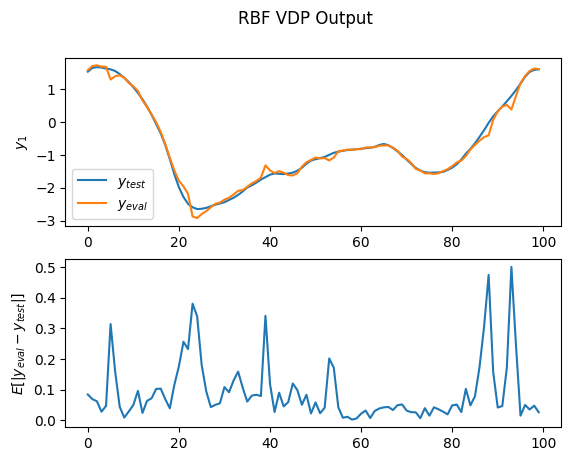

In [27]:


Error = np.mean(np.abs(y_eval.detach().numpy()  - y_test['y_test'].detach().numpy()),1)

fig, axs = plt.subplots(2)
fig.suptitle("RBF VDP Output")
axs[0].plot(y_test['y_test'][:100,1], label="$y_{test}$")
axs[0].plot(y_eval[:100,1].detach().numpy(), label = "$y_{eval}$")
axs[0].legend()

axs[1].plot(Error[:100])
axs[0].set(ylabel="$y_1$")
#axs[1].set(ylabel="theta")
axs[1].set(ylabel="$E[|y_{eval}-y_{test}|]$")
plt.show()

#fig.savefig('RBF_VDP_output.png', format='png')

In [28]:
y_test['y_test'].shape

torch.Size([1993, 4])

In [29]:
y_test


{'y_test': tensor([[ 1.3448,  1.5267,  1.6418,  1.6651],
         [ 1.5267,  1.6418,  1.6651,  1.6523],
         [ 1.6418,  1.6651,  1.6523,  1.6219],
         ...,
         [ 0.7131,  0.5014,  0.3047,  0.0905],
         [ 0.5014,  0.3047,  0.0905, -0.1114],
         [ 0.3047,  0.0905, -0.1114, -0.3067]])}

In [30]:
centers

{'centers': array([[ 0.71076757, -0.49945962,  2.5638273 ,  0.8925996 , -1.8434573 ],
        [ 0.42175063, -0.19575943, -0.7810679 ,  1.7638985 ,  4.121806  ],
        [-0.26576924, -0.22816643,  1.3538045 , -1.2523513 , -3.897896  ],
        [ 0.9788667 , -0.1140917 , -0.19699383, -0.9902704 , -1.6102157 ],
        [-1.5446239 , -0.14280649,  0.37213376,  2.1947298 ,  3.1398432 ],
        [-0.47860685, -0.19668162, -0.51656806, -1.4646419 , -1.91674   ],
        [ 1.7097577 , -1.8625816 , -0.26724648, -1.6077954 , -2.3906178 ],
        [ 1.1042334 ,  0.7912308 ,  0.2884612 ,  1.6543409 ,  1.987633  ],
        [-0.78112715, -0.14151937, -2.5413191 , -0.48282835,  2.4271517 ],
        [ 0.8382461 ,  0.7433404 ,  0.57167226,  1.550313  ,  2.622505  ],
        [-0.7805373 ,  0.13733412, -0.4625243 , -1.3864049 , -1.7851728 ],
        [-0.6146026 ,  1.4604044 ,  2.2378595 ,  1.184483  , -1.246867  ],
        [-0.37077394, -0.387839  ,  2.3480315 ,  0.0135119 , -3.2033496 ],
        [-0.48